In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as d

import math
import scipy.io
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 128

# Download data

Need to download only once (best to leave in comment after)

In [3]:
#subprocess.call([
#     "wget", "-P", "./data/",
#     "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
# ])

In [4]:
# subprocess.call([
#     "wget", "-P", "./data/",
#     "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
# ])

# Load data

In [5]:
def load_amat(path):
    mat = scipy.io.loadmat(path)
    x = mat['X']
    y = mat['y']
    x = np.moveaxis(x, 3, 0)
    x = np.moveaxis(x, 3, 1)
    x = x / 255
    return x.astype(np.float32), y

In [6]:
x_train, y_train = load_amat("data/train_32x32.mat")
x_test, _ = load_amat("data/test_32x32.mat")

In [7]:
# we need y_train to be able to stratify the validation split
x_train, x_val = train_test_split(x_train, test_size=0.1, stratify=y_train)

In [8]:
trainloader = DataLoader(x_train, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(x_val, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(x_test, batch_size=BATCH_SIZE, shuffle=False)

# VAE

In [9]:
class VAE(nn.Module):
    def __init__(self, dim=100):
        super(VAE, self).__init__()

        self.dim = dim

        #ENCODER LAYERS
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3), nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=6),
            nn.ELU())
        self.hidden_1 = nn.Linear(256, 200)

        #DECODER LAYERS
        self.hidden_2 = nn.Linear(100, 256)
        self.decoder = nn.Sequential(
            nn.ELU(),
            nn.Conv2d(
                in_channels=256, out_channels=64, kernel_size=6, padding=5),
            nn.ELU(), nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(
                in_channels=64, out_channels=32, kernel_size=3, padding=2),
            nn.ELU(), nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(
                in_channels=32, out_channels=16, kernel_size=3, padding=2),
            nn.ELU(),
            nn.Conv2d(
                in_channels=16, out_channels=3, kernel_size=3, padding=2),
            nn.Sigmoid())

    def encode(self, x):
        q_params = self.hidden_1(self.encoder(x).view(x.shape[0], 256))
        mu = q_params[:, :self.dim]
        logvar = q_params[:, self.dim:]
        return mu, logvar

    def decode(self, z, x):
        # we need x to abstract from the batch size
        return self.decoder(self.hidden_2(z).view(x.shape[0], 256, 1, 1))

    def sample(self, mu, logvar, x):
        # we need x to abstract from the batch size
        eps = torch.randn(x.shape[0], self.dim).to(device)
        return mu + eps * (0.5 * logvar).exp()

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar, x)
        x_hat = self.decode(z, x)
        return x_hat, mu, logvar

    def criterion(self, x_hat, x, mu, logvar):
        # BCE = -log(p) because gradient descent and not ascent
        BCE = F.mse_loss(x_hat, x, reduction='sum') 
        KLD = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
        # criterion returns -ELBO !
        return (BCE + KLD) / x.shape[0]

    def generate(self, size):
        with torch.no_grad():
            return self.decoder(self.hidden_2(torch.randn(size, self.dim).to(device)).view(size, 256, 1, 1))
        
    
    def evaluate(self, loader):
        with torch.no_grad():
            loss = 0
            for i, data in enumerate(loader, 1):
                # get the inputs
                x = data.to(device)
                x_hat, mu, logvar = self.forward(x)
                loss += self.criterion(x_hat, x, mu, logvar).item()
        return loss / len(loader)

In [10]:
# create model and move it to device
model = VAE()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Let's use {}".format(device))

Let's use cuda:1


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        x = data.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mu, logvar = model.forward(x)

        loss = model.criterion(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print statistics
    train_loss = running_loss / i
    val_loss = model.evaluate(validloader)
    print('epoch {:2d}: loss: {:8.3f}    val_loss: {:8.3f}'.format(
        epoch + 1, train_loss, val_loss))

/home/quentin/venv/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch  1: loss:   57.780    val_loss:   44.147
epoch  2: loss:   41.778    val_loss:   40.275
epoch  3: loss:   39.277    val_loss:   38.456
epoch  4: loss:   38.172    val_loss:   37.886
epoch  5: loss:   37.627    val_loss:   38.088
epoch  6: loss:   37.211    val_loss:   37.165
epoch  7: loss:   36.869    val_loss:   36.878
epoch  8: loss:   36.677    val_loss:   36.551
epoch  9: loss:   36.506    val_loss:   36.806
epoch 10: loss:   36.361    val_loss:   36.424
epoch 11: loss:   36.222    val_loss:   36.063
epoch 12: loss:   36.051    val_loss:   36.133
epoch 13: loss:   35.962    val_loss:   35.931
epoch 14: loss:   35.872    val_loss:   35.923
epoch 15: loss:   35.797    val_loss:   35.766
epoch 16: loss:   35.720    val_loss:   35.629
epoch 17: loss:   35.626    val_loss:   35.649
epoch 18: loss:   35.562    val_loss:   35.655
epoch 19: loss:   35.501    val_loss:   35.636
epoch 20: loss:   35.417    val_loss:   35.340
epoch 21: loss:   35.388    val_loss:   35.572
epoch 22: los

In [12]:
images = model.generate(9).cpu().numpy()

In [13]:
images = np.moveaxis(images, 1, 3)

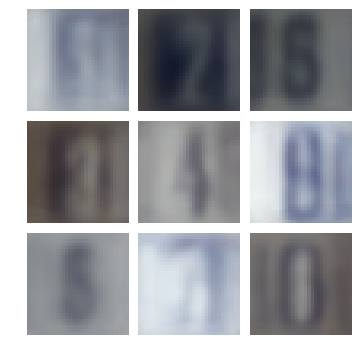

In [14]:
f, axis = plt.subplots(3, 3, figsize=(6,6))

for i, img in enumerate(images, 0):
    axis[math.floor(i/3),i%3].imshow(img)
    axis[math.floor(i/3),i%3].set_axis_off()
    axis[math.floor(i/3),i%3].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.1)
plt.show()